In [2]:
import tensorflow as tf
import numpy as np
import pyaudio
from IPython.display import display
from IPython.display import clear_output
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import larq as lq
import audioop
import pathlib

print("TensorFlow version: ", tf.__version__)

is_recording = True

TensorFlow version:  2.13.0


In [3]:
#Dataset Path

DATASET_PATH = "./current_classes"

data_dir = pathlib.Path(DATASET_PATH)

label_names = np.array(tf.io.gfile.listdir(str(data_dir)))
label_names = label_names[(label_names != 'README.md') & (label_names != '.DS_Store')]
label_names = sorted(label_names)
print("Label names: ", label_names)

Label names:  ['left', 'no', 'right', 'stop', 'yes']


In [4]:
#Import saved model with quantized weights
from tensorflow.keras.models import load_model

FILE_PATH = "./saved_models/model95-5classes"

# FILE_PATH = "./saved_models/model80-35classes"
# label_names.extend(["marvin", "sheila", "up", "down", "off", "on", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "bed", "bird", "cat", "dog", "happy", "house", "tree", "wow", "visual", "backward", "forward", "learn", "follow"])

# label_names = sorted(label_names)
# print(len(label_names))

print(label_names)

with lq.context.quantized_scope(True):
    model = load_model(FILE_PATH)
    weights = model.get_weights()
    
model.summary()

['left', 'no', 'right', 'stop', 'yes']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_quantize_layer (Cus  (None, 124, 129, 1)       0         
 tomQuantizeLayer)                                               
                                                                 
 quant_conv2d (QuantConv2D)  (None, 114, 119, 32)      3872      
                                                                 
 max_pooling2d (MaxPooling2  (None, 38, 39, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 38, 39, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 38, 39, 32)        0         
                 

In [5]:
def preprocess_audio(audio):
    #add a dimension of one to first axis
    audio = np.expand_dims(audio, axis=0)

    #convert to float32
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


In [6]:
def record_audio():
    sample_rate = 16000
    duration = 1  # 1 second
    chunk_size = 1024
    num_chunks = int(sample_rate * duration / chunk_size)

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate, input=True, frames_per_buffer=chunk_size)

    frames = []

    # Record the remaining chunks
    for _ in range(num_chunks - 1):
        data = stream.read(chunk_size)
        frames.append(np.frombuffer(data, dtype=np.int16))

    stream.stop_stream()
    stream.close()
    p.terminate()

    audio = np.concatenate(frames)

    # Pad the recorded audio if the length is less than 16000 samples
    if len(audio) < 16000:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    if audioop.rms(audio, 2) < 800:
        return audio, False
    
    # Normalize the audio samples
    audio = audio.astype(np.float32) / 32767.0

    return audio, True



In [7]:
def predict_from_audio(model):
    global is_recording
    while is_recording:
        audio, isOverThreshold = record_audio()
        if len(audio) > 0 and isOverThreshold:  # Only process audio if it has data (above threshold)
            #print audio sample with matplotlib, small figure
            clear_output(wait=True)
            plt.figure(figsize=(5, 2))        
            plt.plot(audio)
            plt.show()
            spectrogram = preprocess_audio(audio)

            #plot spectrogram with matplotlib
            plt.figure(figsize=(3, 3))
            plt.imshow(tf.squeeze(spectrogram))
            plt.show()

            predicted_word = model.predict(spectrogram)
            print("Predicted word:", label_names[np.argmax(predicted_word)])
            time.sleep(0.2)  # You can adjust the sleep duration to control the loop frequency


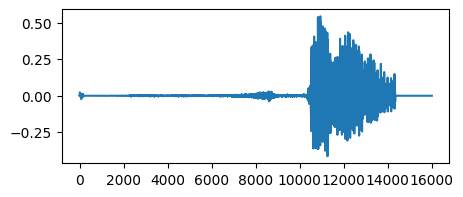

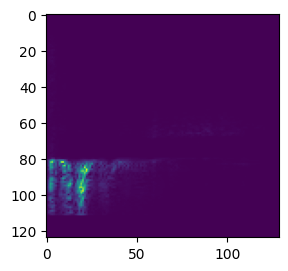

1/1 [==============================] - 0s 14ms/step
Predicted word: stop


In [ ]:
button = widgets.Button(description="Start listening")
button.on_click(lambda x: predict_from_audio(model))

In [9]:
def stop_recording():
    global is_recording
    is_recording = False
    print("Stopped recording")

stop_button = widgets.Button(description="Stop listening")
stop_button.on_click(lambda x: stop_recording())


In [10]:
display(button)
display(stop_button)

Button(description='Start listening', style=ButtonStyle())

Button(description='Stop listening', style=ButtonStyle())